In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML("""
<p style="text-align:center;color:seagreen;font-size:44px;font-weight:bolder;padding:0.3em 0 0.5em;border-radius:10px 10px;font-stretch: 125%;margin:0;line-height:115%;"> Social media Sentiment Analysis</p>
""")


**Social media has evolved into a digital agora, a busy marketplace where ideas are freely exchanged and strong feelings are common However, the overall sentiment of millions of users is concealed behind the surface of likes, shares, and comments, holding a wealth of undiscovered insights. This is where sentiment analysis, a potent instrument that helps us comprehend people's true feelings about companies, goods, and their environment, comes in. It unlocks the language of emotions.**


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize



from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
data = pd.read_csv('/content/Tweets.csv')
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [6]:
print(data.shape)
print(data.columns)

(14640, 15)
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


In [7]:
#Checking Null values
data.isnull().any()

tweet_id                        False
airline_sentiment               False
airline_sentiment_confidence    False
negativereason                   True
negativereason_confidence        True
airline                         False
airline_sentiment_gold           True
name                            False
negativereason_gold              True
retweet_count                   False
text                            False
tweet_coord                      True
tweet_created                   False
tweet_location                   True
user_timezone                    True
dtype: bool

In [8]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
# Extracted necessary column
data=data[['text','airline_sentiment']]
data.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


In [67]:
data['text'][10]

'virginamerica did you know that suicide is the second leading cause of death among teens 1024'

In [10]:
# Find duplicate values in the "text" column
duplicates = data["text"].drop_duplicates()
data.shape

(14640, 2)

In [11]:
#Removing unnecessary charachters
data['text'] = data['text'].map(lambda x: x.lower())
data['text'] = data['text'].map(lambda x: re.sub('[^a-z0-9\s]','', x))
data['text'] = data['text'].str.replace(r'@\S+', '', regex=True)
data.head(10)

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus youve added commercials to ...,positive
2,virginamerica i didnt today must mean i need t...,neutral
3,virginamerica its really aggressive to blast o...,negative
4,virginamerica and its a really big bad thing a...,negative
5,virginamerica seriously would pay 30 a flight ...,negative
6,virginamerica yes nearly every time i fly vx t...,positive
7,virginamerica really missed a prime opportunit...,neutral
8,virginamerica well i didntbut now i do d,positive
9,virginamerica it was amazing and arrived an ho...,positive


In [12]:
#checking values
unique_val=data['airline_sentiment'].value_counts()
unique_val

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

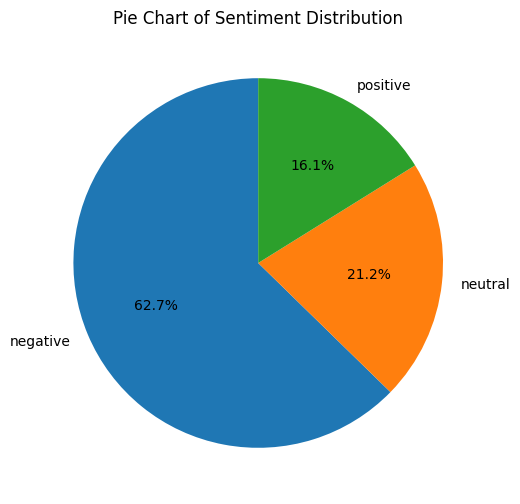

In [13]:
sentiment_counts = data['airline_sentiment'].value_counts()

# Prepare pie chart slice labels and values
labels = sentiment_counts.index.to_list()
values = sentiment_counts.to_list()

# Create the pie chart
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Pie Chart of Sentiment Distribution")

# Display the chart
plt.show()

In [14]:
#checking number of words
def num_of_words(data):
    data['word_count']=data['text'].apply(lambda x:len(str(x).split(" ")))

In [15]:
#checking number of charachters
def num_of_chars(data):
    data['char_count']=data['text'].apply(lambda x:sum(list(map(len,x.split(" ")))))

In [16]:
#Checking StopWrods
def num_of_stop_words(data):
    data['text']=data['text'].apply(lambda x :" ".join(x for x in x.split() if x not in stop_words))

# Feature Extraction Function

In [17]:
def feature_extract(data):
    num_of_words(data)
    num_of_chars(data)
    num_of_stop_words(data)

In [18]:
#Converting to lowercase
def lower_case(data):
    data['text']=data['text'].apply(lambda x :" ".join(x.lower()for x in x.split()))

In [19]:
#Removing Stop Words
stop_words=stopwords.words('english')
def remove_stopwords(data):
    data['stop_wprds']=data['text'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

In [20]:
#Removing virginamerica
def remove_extra_word(data):
    data['text']=data['text'].apply(lambda x:" ".join(x for x in x.split() if x != 'virginamerica'))


In [21]:
#Lemmatization
Word=WordNetLemmatizer()
def lemmatize(data):
    data['text']=data['text'].apply(lambda x:" ".join([Word.lemmatize(word)for word in x.split()]))

In [22]:
def cleaning(data):
    lower_case(data)
    remove_stopwords(data)
    remove_extra_word(data)
    lemmatize(data)

In [24]:
feature_extract(data)
cleaning(data)

In [25]:
data.head()

,text,airline_sentiment,word_count,char_count,stop_wprds
0,dhepburn said,neutral,4,29,0
1,plus youve added commercial experience tacky,positive,9,58,0
2,didnt today must mean need take another trip,neutral,12,54,0
3,really aggressive blast obnoxious entertainmen...,negative,17,103,0
4,really big bad thing,negative,10,44,0


# Tokanization

In [26]:
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [27]:
X

array([[   0,    0,    0, ...,    0,    0,  135],
       [   0,    0,    0, ...,  981, 1108,  113],
       [   0,    0,    0, ...,   71,   79,  108],
       ...,
       [   0,    0,    0, ...,  523,  347,   29],
       [   0,    0,    0, ...,   39,  937,   49],
       [   0,    0,    0, ...,   76,  104,    1]], dtype=int32)

# One-hot encoding & Train Test Split

In [28]:
y = pd.get_dummies(data['airline_sentiment']).values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
# print X , y Shape
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9808, 22) (9808, 3)
(4832, 22) (4832, 3)


In [30]:
y_train

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [31]:
X_train

array([[   0,    0,    0, ...,    0,    6,  762],
       [   0,    0,    0, ...,  878,  496,   11],
       [   0,    0,    0, ...,    1, 1428,  601],
       ...,
       [   0,    0,    0, ...,  284,  102,   15],
       [   0,    0,    0, ...,   30,  120, 1089],
       [   0,    0,    0, ...,   11, 1118,  773]], dtype=int32)

# Model Selection / Building

##Train models

In [33]:
#Ramdom Forest Classifier
from sklearn.metrics import accuracy_score,classification_report
rf = RandomForestClassifier()
model=rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)
print(rf_pred)

if np.argmax(rf_pred) == 0:
    print("negative")
elif np.argmax(rf_pred) == 1:
    print("positive")
elif np.argmax(rf_pred) == 2:
    print("neutral")
rf_acc_score=accuracy_score(y_test,rf_pred)
print("Ramdom Forest Classifier:",rf_acc_score*100)

[[0 0 1]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [0 1 0]
 [1 0 0]]
neutral
Ramdom Forest Classifier: 61.00993377483444


In [63]:
# Random values of tweets
import random as ran

r1 = ran.randint(0, 4832)
print(rf_pred[r1])

if np.argmax(rf_pred[r1]) == 0:
    print("negative")
elif np.argmax(rf_pred[r1]) == 1:
    print("positive")
elif np.argmax(rf_pred[r1]) == 2:
    print("neutral")

rf_acc_score=accuracy_score(y_test,rf_pred)
print("Ramdom Forest Classifier:",rf_acc_score*100)

[0 1 0]
positive
Ramdom Forest Classifier: 60.24420529801324


In [55]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_pred=rf.predict(X_test)
print(rf_pred)

if np.argmax(dt_pred) == 0:
    print("negative")
elif np.argmax(dt_pred) == 1:
    print("positive")
elif np.argmax(dt_pred) == 2:
    print("neutral")

dt_acc_score=accuracy_score(y_test,dt_pred)
print("Decision Tree Classifier:",dt_acc_score*100)

[[0 0 1]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [0 1 0]
 [1 0 0]]
neutral
Decision Tree Classifier: 60.24420529801324


##Model Evaluation

In [38]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
# Calculate and print metrics
accuracy = accuracy_score(y_test, rf_pred)
precision = precision_score(y_test, rf_pred, average='weighted')
recall = recall_score(y_test, rf_pred, average='weighted')
f1 = f1_score(y_test, rf_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print("\n",classification_report(y_test, rf_pred))


Accuracy: 0.6123758278145696
Precision: 0.7062276044061937
Recall: 0.6123758278145696
F1 Score: 0.6146327549784544

               precision    recall  f1-score   support

           0       0.76      0.85      0.80      3085
           1       0.58      0.22      0.32       984
           2       0.66      0.15      0.24       763

   micro avg       0.74      0.61      0.67      4832
   macro avg       0.67      0.41      0.45      4832
weighted avg       0.71      0.61      0.61      4832
 samples avg       0.61      0.61      0.61      4832

